In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython.display import Audio
import librosa
import librosa.display
from tensorflow.contrib import rnn 

# TESTING RNN (TUTORIAL)
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

# prints out full length of array
# np.set_printoptions(threshold=np.nan)

tfrecords_filename = 'D:/Documents/nsynth/nsynth-train.tfrecord'
filter_tfrecords_filename = 'D:/Documents/nsynth/filtered_data_keyboard.tfrecord'

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# parse TFRecord file into a generator
# https://github.com/faroit/nsynth-convert
def nsynth_generator(tfrecords_filename):
    for serialized_example in tf.python_io.tf_record_iterator(tfrecords_filename):
        example = tf.train.Example()
        example.ParseFromString(serialized_example)
        f = example.features.feature
#         result = tf.train.Example.FromString(serialized_example)
#         print(result)

        audio = np.array(f['audio'].float_list.value)

        data = {
            'note':
                f['note'].int64_list.value[0],
            'note_str':
                f['note_str'].bytes_list.value[0],
            'instrument':
                f['instrument'].int64_list.value[0],
            'instrument_str':
                f['instrument_str'].bytes_list.value[0],
            'pitch':
                f['pitch'].int64_list.value[0],
            'velocity':
                f['pitch'].int64_list.value[0],
            'sample_rate':
                f['sample_rate'].int64_list.value[0],
            'audio':
                np.array(f['audio'].float_list.value),
            'qualities':
                np.array(f['qualities'].int64_list.value),
            'qualities_str':
                np.array(f['qualities_str'].bytes_list.value),
            'instrument_family':
                f['instrument_family'].int64_list.value[0],
            'instrument_family_str':
                f['instrument_family_str'].bytes_list.value[0],
            'instrument_source':
                f['instrument_family'].int64_list.value[0],
            'instrument_source_str':
                f['instrument_source_str'].bytes_list.value[0],
        }
#         print(data)

        yield data, audio

In [ ]:
# Filter function to only contain keyboard tag
def filterData(inputFile, outputFile):
    dataset = nsynth_generator(inputFile)
    count = 0
    data = next(dataset)
    writer = tf.python_io.TFRecordWriter(outputFile)
    try:
        while data:
            if data[1]["instrument_family"].int64_list.value[0] == 4:
                writer.write(data[0])
                print(count)
                print(data[2])
                count+=1
            data = next(dataset)
    except StopIteration:
        pass
    writer.close()

In [ ]:
# Testing nsynth_generator function
gen_samples = nsynth_generator(tfrecords_filename)
metadata, audio = next(gen_samples)

In [ ]:
# Filters the 80GB of data to new file total: 51820
outputFile = "filtered_data_keyboard.tfrecord"
filterData(tfrecords_filename, outputFile)

In [ ]:
# Print out all data
# for example in tf.python_io.tf_record_iterator(tfrecords_filename):
for example in tf.python_io.tf_record_iterator(filter_tfrecords_filename):
    result = tf.train.Example.FromString(example)
    print(result)

In [3]:
gen_filter = nsynth_generator(filter_tfrecords_filename)

[0. 0. 0. ... 0. 0. 0.]


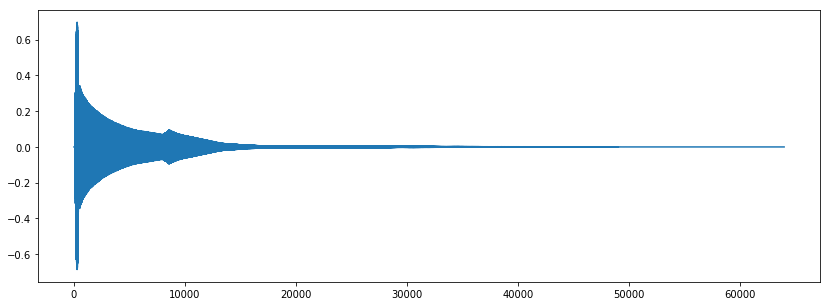

In [4]:
# Filtered data
# metadata, audio = next(gen_filter)
for i in range(5):
    metadata, audio = next(gen_filter)
print(audio)
plt.figure(figsize=(14, 5))
plt.plot(audio)
Audio(audio, rate=metadata['sample_rate'])

1025
8
8
126


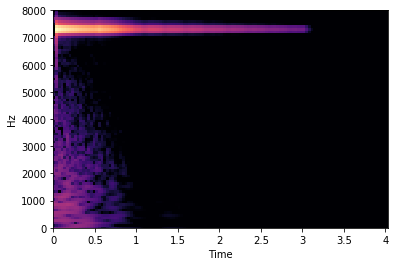

In [5]:
# print(len(audio))
# print(len(metadata['audio']))
CQT = librosa.amplitude_to_db(librosa.magphase(librosa.cqt(audio, sr=16000))[0], ref=np.max)
# plt.figure(figsize=(14, 5))
# print(CQT)
librosa.display.specshow(CQT, sr=metadata['sample_rate'], x_axis='time', y_axis='hz')
S = np.abs(librosa.stft(audio))
comps, acts = librosa.decompose.decompose(S, n_components=8)
print(len(comps))
print(len(comps[0]))
print(len(acts))
print(len(acts[0]))
# print(comps)
# print(acts)

In [6]:
# RNN code
# source: https://pythonprogramming.net/rnn-tensorflow-python-machine-learning-tutorial/
hm_epochs = 3
n_classes = 10
batch_size = 128

chunk_size = 126
n_chunks = 84
rnn_size = 128

hm_epochs = 3
n_classes = 10
batch_size = 128
chunk_size = 28
n_chunks = 28
rnn_size = 128

In [7]:
x = tf.placeholder('float', [None, n_chunks, chunk_size])
y = tf.placeholder('float')
print(x.get_shape())

(?, 28, 28)


In [8]:
def recurrent_neural_network(x):
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size,n_classes])),
             'biases':tf.Variable(tf.random_normal([n_classes]))}
    print(x.get_shape())
    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, chunk_size])
    print(x.get_shape())
    x = tf.split(x, n_chunks, 0)
    print(len(x))
    print(x)
    lstm_cell = rnn.BasicLSTMCell(rnn_size,state_is_tuple=True) 
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    output = tf.matmul(outputs[-1],layer['weights']) + layer['biases']

    return output

In [ ]:
# REFERENCE CODE
def train_neural_network(x):
#     tf.reset_default_graph()
    prediction = recurrent_neural_network(x)
    # OLD VERSION:
    #cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    # NEW:
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    

    with tf.Session() as sess:
        # OLD:
        #sess.run(tf.initialize_all_variables())
        # NEW:
        sess.run(tf.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(mnist.train.num_examples/batch_size)):
#             for metadata, audio in gen_filter:
                ## need to change batch to audio
                epoch_x, epoch_y = mnist.train.next_batch(batch_size)
                epoch_x = epoch_x.reshape((batch_size, n_chunks, chunk_size))
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                epoch_loss += c

            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval({x:mnist.test.images.reshape((-1, n_chunks, chunk_size)), y:mnist.test.labels}))
        sess.close()

train_neural_network(x)

In [ ]:
int(mnist.train.num_examples)

In [ ]:
# MODIFIED CODE
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cnt = 0
    gen_filter = nsynth_generator(filter_tfrecords_filename)
    metadata, audio = next(gen_filter)

    for epoch in range(hm_epochs):
        epoch_loss = 0   
        cnt=0
#         try:
#             while metadata:
#                 if(cnt == 25): break
                
#                 X = librosa.cqt(audio)
#                 Xdb = librosa.amplitude_to_db(abs(X))
#                 print(len(X))
#                 print(len(X[0]))
#                 librosa.display.specshow(Xdb, sr=metadata['sample_rate'], x_axis='time', y_axis='hz')
                
# #                 epoch_x, epoch_y = mnist.train.next_batch(batch_size)           
# #                 epoch_x = epoch_x.reshape((batch_size, n_chunks, chunk_size))
# #                 _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
# #                 epoch_loss += c 
                
#                 metadata, audio = next(gen_filter)
#                 cnt += 1
#         except StopIteration:
#             pass
        for metadata, audio in gen_filter:
            if(cnt == 5): break
            print(metadata)
            cnt += 1
        print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)
        
        # Filter function to only contain keyboard tag
#             print(epoch_y)
            ## need to change batch to audio
#             epoch_x = epoch_x.reshape((batch_size, n_chunks, chunk_size))
#             _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
#             epoch_loss += c

#         print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

#     correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

#     accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
#     print('Accuracy:',accuracy.eval({x:mnist.test.images.reshape((-1, n_chunks, chunk_size)), y:mnist.test.labels}))
    sess.close()


In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [9]:
prediction = recurrent_neural_network(x)

(?, 28, 28)
(?, 28)
28
[<tf.Tensor 'split:0' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:5' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:6' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:7' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:8' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:9' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:10' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:11' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:12' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:13' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:14' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:15' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:16' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:17' shape=(?, 28) dtype=float32>, <tf.Tensor 'split:18' shape=(?, 28) dtype=float32>

In [10]:
print(prediction)

Tensor("add:0", shape=(?, 10), dtype=float32)
